In [2]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 MB 1.1 MB/s eta 0:00:0000:0100:02


In [10]:
!pip3 install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1.5 MB/s eta 0:00:00a 0:00:01


In [2]:
%time

import cv2
import numpy as np

def extract_frames_from_video(video_path, take_every_n_frame = 50):
    # Открываем видеофайл
    cap = cv2.VideoCapture(video_path)
    
    # Проверяем, удалось ли открыть видеофайл
    if not cap.isOpened():
        print(f"Ошибка: не удалось открыть видеофайл {video_path}")
        return []

    frames = []
    c = 0
    
    while cap.isOpened():
        # Читаем кадр за кадром
        ret, frame = cap.read()
        c+=1
        
        if not ret:
            break
        
        # Добавляем кадр в список
        if c%take_every_n_frame == 0: frames.append(frame)
    
    # Освобождаем захват видео
    cap.release()
    
    return np.array(frames)

# Пример использования
video_path = '/Users/polinanazarova/Desktop/2ef3ec7442459323bfb283992ffe001f.mp4'
frames = extract_frames_from_video(video_path)
print(f"Извлечено {len(frames)} кадров из видео")

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 7.39 μs
Извлечено 1089 кадров из видео


# HOG
Высокие значения: высокое среднее значение HOG дескрипторов указывает на наличие множества объектов, деталей и сложных текстур. Это может свидетельствовать о насыщенности сцены.
Низкие значения: низкое среднее значение указывает на то, что изображение содержит большие однородные области без значительных перепадов яркости, что характерно для простых изображений без множества объектов и деталей.

In [3]:
import time
from skimage.feature import hog

start_time = time.time()

average_hogs = []
for i in range(len(frames)):
    # Загрузка изображения
    image = cv2.cvtColor(frames[i],cv2.COLOR_RGB2GRAY)
    
    #Вычисление HOG
    fd = hog(image, pixels_per_cell=(16, 16), cells_per_block=(4, 4))
    # Вычисление среднего значения HOG дескрипторов
    average_hog_descriptor = np.mean(fd) #выше коэффициент - больше деталей и обьектов в изображении
    average_hogs.append(average_hog_descriptor)

end_time = time.time()
execution_time = end_time - start_time
print(f"Время выполнения: {execution_time} секунд")


Время выполнения: 40.0461208820343 секунд


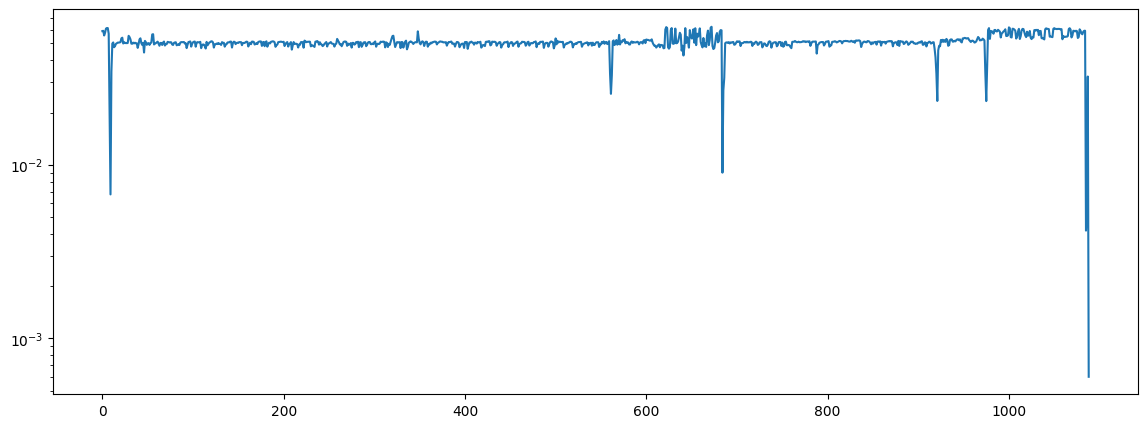

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 5))
plt.semilogy(average_hogs)
plt.show()

1. Контраст (Contrast)
Низкий контраст (приблизительно 0 - 0.5): Указывает на однородное изображение без резких изменений в яркости.
Средний контраст (приблизительно 0.5 - 1.5): Указывает на изображение с умеренными изменениями в яркости.
Высокий контраст (более 1.5): Указывает на изображение с резкими переходами и большим количеством деталей и объектов.
2. Энергия (Energy)
Низкая энергия (приблизительно 0 - 0.1): Указывает на сложную текстуру с большим разнообразием интенсивностей.
Средняя энергия (приблизительно 0.1 - 0.3): Указывает на умеренно сложную текстуру.
Высокая энергия (более 0.3): Указывает на однородное изображение с малым количеством текстурных элементов.
3. Гомогенность (Homogeneity)
Низкая гомогенность (приблизительно 0 - 0.4): Указывает на изображение с разнородной текстурой и большим количеством различных элементов.
Средняя гомогенность (приблизительно 0.4 - 0.7): Указывает на изображение с умеренной разнородностью.
Высокая гомогенность (более 0.7): Указывает на очень однородное изображение с малым количеством текстурных элементов.
4. Корреляция (Correlation)
Низкая корреляция (приблизительно 0 - 0.5): Указывает на низкую предсказуемость значений пикселей и разнообразную текстуру.
Средняя корреляция (приблизительно 0.5 - 0.8): Указывает на умеренную предсказуемость.
Высокая корреляция (более 0.8): Указывает на высокую предсказуемость значений интенсивностей пикселей, что характерно для однородных изображений.

In [4]:
import time
from skimage.feature import hog, graycomatrix, graycoprops

start_time = time.time()

haralick_params = {'rev_contrast':[],'energy':[],'homogeneity':[],'correlation':[]}
for input_image in frames:
    # Вычисление GLCM
    glcm = graycomatrix(image, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    
    # Извлечение Haralick характеристик
    '''Высокий контраст указывает на большой диапазон интенсивностей и существенные изменения яркости, 
    что характерно для изображений с многочисленными объектами и деталями.'''
    contrast = graycoprops(glcm, 'contrast')[0, 0]

    '''Высокая энергия свидетельствует о гомогенности и однородности текстуры. Низкая энергия указывает на большую текстурную сложность.'''
    energy = graycoprops(glcm, 'energy')[0, 0]

    '''Высокая гомогенность указывает на наличие большей части одинаковых значений интенсивности, 
    тогда как низкая гомогенность указывает на более разнообразные и сложные текстуры.'''
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]

    '''Высокая корреляция указывает на предсказуемость значений яркости (т.е. менее насыщенные текстуры), 
    тогда как низкая корреляция указывает на более разрозненные текстуры.'''
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    #Сделаем так, чтобы в итоговом параметре каждый из составляющих параметров был прямо пропоционален увеличению сложности и насыщенности изображения
    haralick_params['rev_contrast'].append(1/(contrast+0.000001))
    haralick_params['energy'].append(energy)
    haralick_params['homogeneity'].append(homogeneity)
    haralick_params['correlation'].append(correlation)

end_time = time.time()
execution_time = end_time - start_time
print(f"Время выполнения: {execution_time} секунд")

len(haralick_params)

Время выполнения: 2.0100789070129395 секунд


4

In [8]:
np.std( haralick_params['homogeneity'])

np.float64(1.1102230246251565e-16)

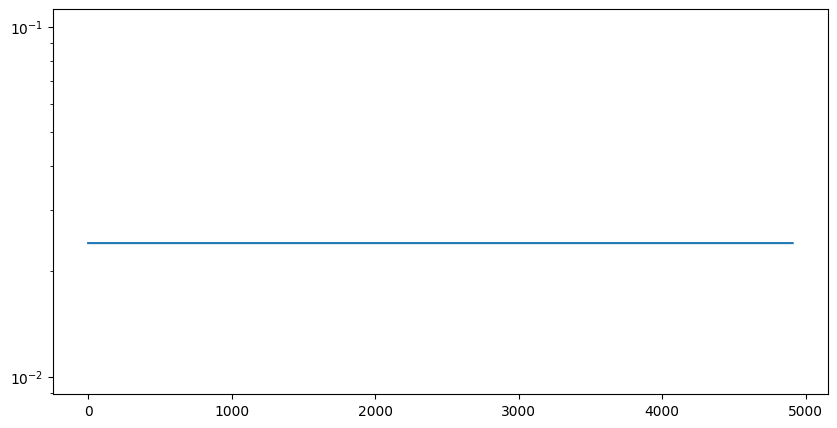

In [91]:
plt.figure(figsize=(14, 5))
plt.semilogy(average_hogs)
plt.show()

Низкая энтропия: Указывает на то, что изображение содержит большие однородные области. Например, фотографии с равномерными фонами или малым количеством текстур имеют низкую энтропию.
Высокая энтропия: Указывает на то, что изображение содержит много деталей, шумов и резких переходов. Например, фотографии с большим количеством мелких объектов, текстур или шумов имеют высокую энтропию.

In [5]:
start_time = time.time()

entropies = []
for input_image in frames:
    # Загрузка изображения
    image = cv2.cvtColor(input_image,cv2.COLOR_RGB2GRAY)
   
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    # Нормализация гистограммы
    hist = hist / np.sum(hist)
    
    # Вычисление меры энтропии
    entropy = -np.sum(hist * np.log2(hist + 1e-10))
    entropies.append(entropy)

end_time = time.time()
execution_time = end_time - start_time
print(f"Время выполнения: {execution_time} секунд")

len(entropies)

Время выполнения: 0.5117208957672119 секунд


1089

Таким образом получаем для каждого кадра положительную или отрицательную метрику, показывающую его энтропию относительно других кадров

In [7]:
entropies_ = entropies-np.mean(entropies) 

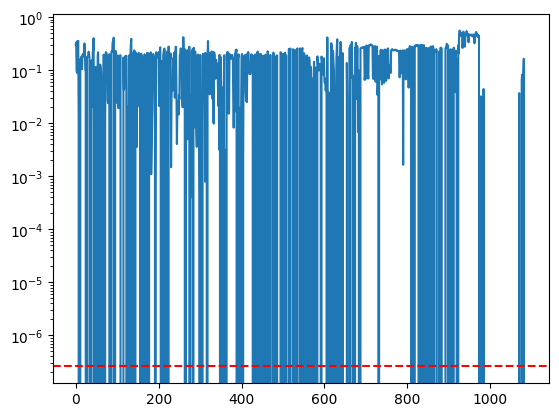

In [8]:
plt.semilogy(entropies_)
plt.axhline(np.mean(entropies_), color='r', linestyle='--')
plt.show()

In [9]:
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
mspf = 1000/fps #milliseconds per frame
mspf

33.333333333333336

In [10]:
len(frames)/fps

36.3

In [12]:
k = 0.1

more_detailed_than_usual_frame_indexes = np.where((entropies_ > np.mean(entropies_)+k*np.std(entropies_)) & (average_hogs > np.mean(average_hogs)+k*np.std(average_hogs)))[0]

less_detailed_than_usual_frame_indexes = np.where((entropies_ < np.mean(entropies_)-k*np.std(entropies_)) & (average_hogs < np.mean(average_hogs)-k*np.std(average_hogs)))[0]

In [13]:
len(more_detailed_than_usual_frame_indexes),len(less_detailed_than_usual_frame_indexes)

(123, 85)

In [21]:
coef = []

for ind in list(more_detailed_than_usual_frame_indexes)+list(less_detailed_than_usual_frame_indexes):
    coef.append([ ( round((abs(int(ind)-1)*mspf)), round((int(ind)+1)*mspf) ) ,float(entropies_[ind]+ average_hogs[ind]) ])

coef.sort(key=lambda x: x[1], reverse=True)

print(coef)

[[(31400, 31467), 0.6040039523419566], [(30867, 30933), 0.5990386688403363], [(31133, 31200), 0.5903497963430908], [(32167, 32233), 0.585600277801935], [(31167, 31233), 0.579620338664467], [(31433, 31500), 0.576492175736332], [(31000, 31067), 0.5641826510589953], [(32200, 32267), 0.5631877743704686], [(32133, 32200), 0.5582344521436093], [(31033, 31100), 0.5547475512909841], [(31367, 31433), 0.5471895955671341], [(30800, 30867), 0.5437167622388004], [(32233, 32300), 0.5404815903712283], [(31500, 31567), 0.5385902869876024], [(31667, 31733), 0.5277578418844031], [(31933, 32000), 0.5277305334413074], [(31600, 31667), 0.5261447294399431], [(31767, 31833), 0.5246838277413427], [(31467, 31533), 0.5244813891384699], [(32333, 32400), 0.5236254095268642], [(31633, 31700), 0.5226546467858706], [(31800, 31867), 0.5220379726219729], [(31200, 31267), 0.5193445042671908], [(31967, 32033), 0.5171086216694917], [(31700, 31767), 0.5128428705039252], [(31733, 31800), 0.5116245048414205], [(31833, 31900

In [15]:
import cv2
import numpy as np
import time
from skimage.feature import hog

def extract_frames_from_video(video_path, take_every_n_frame = 50):
    # Открываем видеофайл
    cap = cv2.VideoCapture(video_path)
    
    # Проверяем, удалось ли открыть видеофайл
    if not cap.isOpened():
        print(f"Ошибка: не удалось открыть видеофайл {video_path}")
        return []

    frames = []
    c = 0
    
    while cap.isOpened():
        # Читаем кадр за кадром
        ret, frame = cap.read()
        c+=1
        
        if not ret:
            break
        
        # Добавляем кадр в список
        if c%take_every_n_frame == 0: frames.append(frame)
    
    # Освобождаем захват видео
    cap.release()
    
    return np.array(frames)

def get_the_most_complicated_frames(video_path, take_every_n_frame = 50):
    frames = extract_frames_from_video(video_path, take_every_n_frame)
    print(f"Извлечено {len(frames)} кадров из видео")

    average_hogs = []
    for i in range(len(frames)):
        # Загрузка изображения
        image = cv2.cvtColor(frames[i],cv2.COLOR_BGR2GRAY)
        
        #Вычисление HOG
        fd = hog(image, pixels_per_cell=(16, 16), cells_per_block=(4, 4))
        # Вычисление среднего значения HOG дескрипторов
        average_hog_descriptor = np.mean(fd) #выше коэффициент - больше деталей и обьектов в изображении
        average_hogs.append(average_hog_descriptor)
        
    entropies = []
    for input_image in frames:
        # Загрузка изображения
        image = cv2.cvtColor(input_image,cv2.COLOR_RGB2GRAY)
       
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        # Нормализация гистограммы
        hist = hist / np.sum(hist)
        
        # Вычисление меры энтропии
        entropy = -np.sum(hist * np.log2(hist + 1e-10))
        entropies.append(entropy)

    entropies_ = entropies-np.mean(entropies) 

    k = 0.1

    more_detailed_than_usual_frame_indexes = np.where((entropies_ > np.mean(entropies_)+k*np.std(entropies_)) & 
                                                      (average_hogs > np.mean(average_hogs)+k*np.std(average_hogs)))[0]
    less_detailed_than_usual_frame_indexes = np.where((entropies_ < np.mean(entropies_)-k*np.std(entropies_)) & 
                                                      (average_hogs < np.mean(average_hogs)-k*np.std(average_hogs)))[0]
    
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    mspf = 1000/fps #milliseconds per frame

    coef = []

    for ind in list(more_detailed_than_usual_frame_indexes):
        coef.append([ ( round((abs(int(ind)-1)*mspf)), round((int(ind)+1)*mspf) ), abs(float(entropies_[ind]+ average_hogs[ind])) ])

    for ind in list(less_detailed_than_usual_frame_indexes):
        coef.append([ ( round((abs(int(ind)-1)*mspf)), round((int(ind)+1)*mspf) ), -1*abs(float(entropies_[ind]+ average_hogs[ind])) ])
    
    coef.sort(key=lambda x: x[0][0])
    
    return coef

    

# Пример использования
start_time = time.time()

video_path = '/Users/polinanazarova/Desktop/2ef3ec7442459323bfb283992ffe001f.mp4'
coml_coef = get_the_most_complicated_frames(video_path)

end_time = time.time()
execution_time = end_time - start_time
print(f"Время выполнения: {execution_time} секунд")

Извлечено 1089 кадров из видео
Время выполнения: 75.15554404258728 секунд


In [17]:
coml_coef.sort(key=lambda x: x[1], reverse = True)
coml_coef

[[(31400, 31467), 0.6037318808419743],
 [(30867, 30933), 0.5987885366796197],
 [(31133, 31200), 0.5901204371813331],
 [(32167, 32233), 0.5853928402840038],
 [(31167, 31233), 0.5793548657196864],
 [(31433, 31500), 0.5761973790515885],
 [(31000, 31067), 0.5639770488881102],
 [(32200, 32267), 0.5628802033133874],
 [(32133, 32200), 0.5580715879163398],
 [(31033, 31100), 0.5544893010658527],
 [(31367, 31433), 0.5469033347803143],
 [(30800, 30867), 0.5434405464900525],
 [(32233, 32300), 0.540134556753218],
 [(31500, 31567), 0.5382850809046087],
 [(31667, 31733), 0.527440720179505],
 [(31933, 32000), 0.5273959018156938],
 [(31600, 31667), 0.525824901966289],
 [(31767, 31833), 0.524399934690482],
 [(31467, 31533), 0.5241877217341656],
 [(32333, 32400), 0.5233195860670374],
 [(31633, 31700), 0.5222970491728566],
 [(31800, 31867), 0.5217831785318304],
 [(31200, 31267), 0.5191106295011253],
 [(31967, 32033), 0.5168481964181657],
 [(31700, 31767), 0.5125303446359851],
 [(31733, 31800), 0.511329725

In [25]:
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
mspf = 1000/fps #milliseconds per frame
700/mspf

21.0

In [19]:
frames = extract_frames_from_video(video_path)
print(f"Извлечено {len(frames)} кадров из видео")
frames[942]

Извлечено 1089 кадров из видео


array([[[  9,   6,  13],
        [  9,   6,  13],
        [ 10,   9,  13],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       [[  9,   6,  13],
        [  9,   6,  13],
        [ 10,   9,  13],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       [[  9,   6,  13],
        [  9,   6,  13],
        [ 10,   9,  13],
        ...,
        [253, 253, 253],
        [253, 253, 253],
        [253, 253, 253]],

       ...,

       [[ 13,  16,   9],
        [ 13,  16,   9],
        [ 13,  16,   9],
        ...,
        [210, 212, 211],
        [210, 212, 211],
        [210, 212, 211]],

       [[ 15,  17,  10],
        [ 15,  17,  10],
        [ 15,  17,  10],
        ...,
        [209, 212, 209],
        [210, 214, 210],
        [210, 214, 210]],

       [[ 15,  17,  10],
        [ 15,  17,  10],
        [ 15,  17,  10],
        ...,
        [209, 212, 209],
        [210, 214, 210],
        [210, 214, 210]]

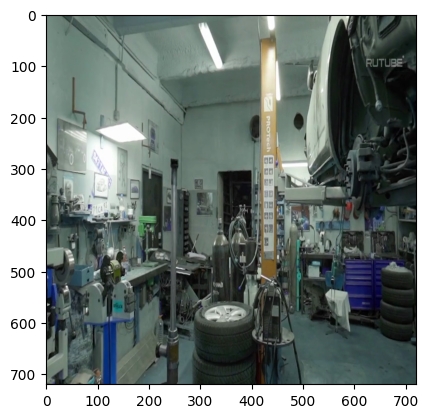

In [26]:
from matplotlib import pyplot as plt

# call imshow() using plt object 
plt.imshow(np.array(frames[21])) 
  
# display that image 
plt.show() 